<a style="float:left;" href="https://colab.research.google.com/github/ClaudeCoulombe/VIARENA/blob/master/Labos/Lab-Detection_Objets/Detection_Objets-colab.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
<br/>
### Rappel - Fonctionnement d'un carnet web iPython

* Pour exécuter le code contenu dans une cellule d'un carnet iPython, cliquez dans la cellule et faites (⇧↵, shift-enter) 
* Le code d'un carnet iPython s'exécute séquentiellement de haut en bas de la page. Souvent, l'importation d'une bibliothèque Python ou l'initialisation d'une variable est préalable à l'exécution d'une cellule située plus bas. Il est donc recommandé d'exécuter les cellules en séquence. Enfin, méfiez-vous des retours en arrière qui peuvent réinitialiser certaines variables.
* Pour obtenir de l'information sur une fonction, utilisez la commande Python `help(`"nom de la fonction"`)`

SVP, déployez toutes les cellules en sélectionnant l'item « Développer les rubriques » de l'onglet « Affichage ».

# Détection d'objets

Bien que manquant de temps et d'espace pour traiter sérieusement de la tâche de détection d'objets, voici un petit labo Colab «en prime» pour vous mettre en appétit sur ce sujet plein d'applications.

Rappelons que la détection consiste à identifier les différents objets dans une image en les encadrant dans un rectangle.

La détection d'objets est utilisée pour identifier, isoler et même compter des objets dans une image, cela inclut le comptage du bétail dans un enclos, l'estimation du nombre d'arbres dans une forêt, ou le comptage du nombre de poissons dans une passe migratoire.

## Modèle créé à l'aide de la bibliothèque spécialisée en détection d'objets de TensorFlow

<p>Utilisation de la <a href="https://github.com/tensorflow/models/tree/master/research/object_detection" target='_blank'>bibliothèque spécialisée en détection d'objets de TensorFlow</a> et de son IPA (<i>API</i>) de haut niveau. La bibliothèque de détection d'objets TensorFlow utilise l'algorithme R-CNN plus rapide (<i>Faster R-CNN</i>) avec un extracteur d'attributs visuels basé sur l'architecture de réseau convolutif profond <a href="https://paperswithcode.com/method/inception-resnet-v2" target='_blank'>Inception Resnet v2</a>. Le modèle est entraîné par apprentissage par transfert à partir d'un modèle préentraîné sur Imagenet puis peaufiné sur l'ensemble de données <a href="https://cocodataset.org/#home" target='_blank'>COCO</a> 2017 avec des lots de 64 images en couleur de 640 par 640 pixels.</p>

### L'algorithme <code>Faster R-CNN</code>

Voici une tentative d'explication des étapes principales de l'algorithme <code>R-CNN plus rapide</code>:

<ul>
    <ol>
        <li>Un réseau convolutif profond, d'architecture <a href="https://paperswithcode.com/method/inception-resnet-v2" target='_blank'>Inception Resnet v2</a>, extrait une représentation des attributs visuels de l’image d'entrée;</li> 
        <li>Cette représentation passe à un réseau dit de proposition de régions (en anglais, <i>region proposal network</i> ou <i>RPN</i>), qui génère des propositions de régions qui sont des rectangles qui délimitent les objets pertinents de l’image. Pour cela, le réseau de proposition de régions utilise des rectangles de taille fixe placés uniformément sur l’image originale afin de détecter les objets par balayage;</li>
        <li>Les régions candidates sont ensuite filtrées par un algorithme dit de suppression des non-maxima (en anglais, <i>non-maximum suppression</i>), appelé aussi <a href="https://fr.wikipedia.org/wiki/Filtre_de_Canny" target='_blank'>filtre de Canny</a>, qui ne conserve que les régions les plus prometteuses en se basant sur la netteté de leurs contours;</li> 
        <li>La représentation des attributs visuels de l’image d'entrée 1) et les rectangles de délimitation des objets pertinents 3) sont combinés pour générer une nouvelle représentation par sous-échantillonnage (<i>pooling</i>) des régions d'intérêt (en anglais, <i>regions of interest</i> ou <i>RoI</i>);</li>
        <li>Finalement, la représentation des régions d'intérêt passe dans un perceptron multicouche pour la prédiction des coordonnées (par régression) des rectangles contenant des objets et la prédiction (par classification softmax) des classes d'objets.</li> 
    </ol>
</ul>

### Inspiration et droits d'auteur

Ce laboratoire est une adaptation et modification directe du tutoriel <a href="https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_640x640/1" target='_blank'>TensorFlow Hub Object Detection</a> - site Google / TensorFlow Hub

##### Copyright (c) 2020, The TensorFlow Hub Authors.
##### Copyright (c) 2022, Claude COULOMBE, modifications et adaptation française

Le contenu de cette page est sous licence <a href="https://creativecommons.org/licenses/by/3.0/deed.fr" target='_blank'>Creative Commons Attribution 3.0 (CC BY 3.0)</a>,<br/>et les exemples de code sont sous <a href="https://www.apache.org/licenses/LICENSE-2.0" target='_blank'>licence Apache 2.0</a>.

#### Données

Les données sur les images du jeux de données <a href="https://cocodataset.org/#home" target='_blank'>COCO</a> (<i>Common Objects in Context</i>) de Microsoft, une banque en données ouvertes sous licence <a href="https://creativecommons.org/licenses/by/4.0/deed.fr" target='_blank'>Creative Commons Attribution 4.0 (CC BY 4.0)</a> de 330 000 photos de 80 objets communs dans leur contexte.</p>

## Fixer le hasard pour la reproductibilité

La mise au point de réseaux de neurones implique certains processus aléatoires. Afin de pouvoir reproduire et comparer vos résultats d'expérience, vous fixez temporairement l'état aléatoire grâce à un germe aléatoire unique.

Pendant la mise au point, vous fixez temporairement l'état aléatoire pour la reproductibilité mais vous répétez l'expérience avec différents germes ou états aléatoires et prenez la moyenne des résultats.
<br/>
**Note** : Pour un système en production, vous ravivez simplement l'état  purement aléatoire avec l'instruction `GERME_ALEATOIRE = None`

In [1]:
# This Colab requires TF 2.5.
# !pip3 install -U "tensorflow>=2.5"

In [2]:
import tensorflow as tf
print("Version TensorFlow:",tf.__version__)

Version TensorFlow: 2.9.2


In [3]:
import os

# Définir un germe aléatoire
GERME_ALEATOIRE = 42

# Définir un état aléatoire pour Python
os.environ['PYTHONHASHSEED'] = str(GERME_ALEATOIRE)

# Définir un état aléatoire pour Python random
import random
random.seed(GERME_ALEATOIRE)

# Définir un état aléatoire pour NumPy
import numpy as np
np.random.seed(GERME_ALEATOIRE)

# Définir un état aléatoire pour TensorFlow

tf.random.set_seed(GERME_ALEATOIRE)

# Note: Retrait du comportement déterministe
# à cause de keras.layers.RandomContrast(...)
# dont il n'existe pas de version déterministe
# os.environ['TF_DETERMINISTIC_OPS'] = '1'
# os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

print("Germe aléatoire fixé")

Germe aléatoire fixé


In [4]:
import os
import pathlib

import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from six.moves.urllib.request import urlopen

import tensorflow as tf
import tensorflow_hub as hub

tf.get_logger().setLevel('ERROR')

print("Bibliothèques importées")

Bibliothèques importées


## Utilitaires

Exécutez le code de la cellule suivante pour créer des utilitaires

* Méthode pour charger une image
* Liste de tous les modèles de TensorFlow Hub
* Liste des tuples avec les points d'ancrage pour des poses humaines pour le jeu de données COCO 2017. Ceci est nécessaire pour les modèles impliquant des humains dont on analyse les poses.

In [5]:
def lecture_image(chemin_vers_fichier):
    """
    Lecture et chargement d'une image à partir d'un fichier 
    local ou moissonné sur la Toile. L'image est stockée dans
    dans un tableau NumPy de dimensions (hauteur,largeur,canaux)
    où canaux=3 pour une image couleur RVB.
    Arguments:
       le chemin vers le fichier de l'image
    Sortie:
       un tableau Numpy (image_hauteur,image_largeur,3)
    """
    image = None
    if(chemin_vers_fichier.startswith('http')):
        reponse = urlopen(chemin_vers_fichier)
        image = reponse.read()
        image = BytesIO(image)
        image = Image.open(image)
    else:
        image = tf.io.gfile.GFile(chemin_vers_fichier, 'rb').read()
        image = Image.open(BytesIO(image))
    (image_largeur, image_hauteur) = image.size
    return np.array(image.getdata()).reshape((1, image_hauteur, image_largeur, 3)).astype(np.uint8)

TOUS_LES_MODELES_DU_HUB_TENSORFLOW = {
    'CenterNet HourGlass104 512x512' : 'https://tfhub.dev/tensorflow/centernet/hourglass_512x512/1',
    'CenterNet HourGlass104 Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/hourglass_512x512_kpts/1',
    'CenterNet HourGlass104 1024x1024' : 'https://tfhub.dev/tensorflow/centernet/hourglass_1024x1024/1',
    'CenterNet HourGlass104 Keypoints 1024x1024' : 'https://tfhub.dev/tensorflow/centernet/hourglass_1024x1024_kpts/1',
    'CenterNet Resnet50 V1 FPN 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v1_fpn_512x512/1',
    'CenterNet Resnet50 V1 FPN Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v1_fpn_512x512_kpts/1',
    'CenterNet Resnet101 V1 FPN 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet101v1_fpn_512x512/1',
    'CenterNet Resnet50 V2 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v2_512x512/1',
    'CenterNet Resnet50 V2 Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v2_512x512_kpts/1',
    'EfficientDet D0 512x512' : 'https://tfhub.dev/tensorflow/efficientdet/d0/1',
    'EfficientDet D1 640x640' : 'https://tfhub.dev/tensorflow/efficientdet/d1/1',
    'EfficientDet D2 768x768' : 'https://tfhub.dev/tensorflow/efficientdet/d2/1',
    'EfficientDet D3 896x896' : 'https://tfhub.dev/tensorflow/efficientdet/d3/1',
    'EfficientDet D4 1024x1024' : 'https://tfhub.dev/tensorflow/efficientdet/d4/1',
    'EfficientDet D5 1280x1280' : 'https://tfhub.dev/tensorflow/efficientdet/d5/1',
    'EfficientDet D6 1280x1280' : 'https://tfhub.dev/tensorflow/efficientdet/d6/1',
    'EfficientDet D7 1536x1536' : 'https://tfhub.dev/tensorflow/efficientdet/d7/1',
    'SSD MobileNet v2 320x320' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2',
    'SSD MobileNet V1 FPN 640x640' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v1/fpn_640x640/1',
    'SSD MobileNet V2 FPNLite 320x320' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_320x320/1',
    'SSD MobileNet V2 FPNLite 640x640' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_640x640/1',
    'SSD ResNet50 V1 FPN 640x640 (RetinaNet50)' : 'https://tfhub.dev/tensorflow/retinanet/resnet50_v1_fpn_640x640/1',
    'SSD ResNet50 V1 FPN 1024x1024 (RetinaNet50)' : 'https://tfhub.dev/tensorflow/retinanet/resnet50_v1_fpn_1024x1024/1',
    'SSD ResNet101 V1 FPN 640x640 (RetinaNet101)' : 'https://tfhub.dev/tensorflow/retinanet/resnet101_v1_fpn_640x640/1',
    'SSD ResNet101 V1 FPN 1024x1024 (RetinaNet101)' : 'https://tfhub.dev/tensorflow/retinanet/resnet101_v1_fpn_1024x1024/1',
    'SSD ResNet152 V1 FPN 640x640 (RetinaNet152)' : 'https://tfhub.dev/tensorflow/retinanet/resnet152_v1_fpn_640x640/1',
    'SSD ResNet152 V1 FPN 1024x1024 (RetinaNet152)' : 'https://tfhub.dev/tensorflow/retinanet/resnet152_v1_fpn_1024x1024/1',
    'Faster R-CNN ResNet50 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_640x640/1',
    'Faster R-CNN ResNet50 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_1024x1024/1',
    'Faster R-CNN ResNet50 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_800x1333/1',
    'Faster R-CNN ResNet101 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_640x640/1',
    'Faster R-CNN ResNet101 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_1024x1024/1',
    'Faster R-CNN ResNet101 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_800x1333/1',
    'Faster R-CNN ResNet152 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_640x640/1',
    'Faster R-CNN ResNet152 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_1024x1024/1',
    'Faster R-CNN ResNet152 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_800x1333/1',
    'Faster R-CNN Inception ResNet V2 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_640x640/1',
    'Faster R-CNN Inception ResNet V2 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_1024x1024/1',
    'Mask R-CNN Inception ResNet V2 1024x1024' : 'https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1'
}

IMAGES_TEST = {
  "Plage" : "models/research/object_detection/test_images/image2.jpg",
  "Chiens" : "models/research/object_detection/test_images/image1.jpg",
  # By Heiko Gorski, Source: https://commons.wikimedia.org/wiki/File:Naxos_Taverna.jpg
  "Taverne à Naxos" : "https://upload.wikimedia.org/wikipedia/commons/6/60/Naxos_Taverna.jpg",
  # Source: https://commons.wikimedia.org/wiki/File:The_Coleoptera_of_the_British_islands_(Plate_125)_(8592917784).jpg
  "Bibittes" : "https://upload.wikimedia.org/wikipedia/commons/1/1b/The_Coleoptera_of_the_British_islands_%28Plate_125%29_%288592917784%29.jpg",
  # By Américo Toledano, Source: https://commons.wikimedia.org/wiki/File:Biblioteca_Maim%C3%B3nides,_Campus_Universitario_de_Rabanales_007.jpg
  "Téléphones" : 'https://upload.wikimedia.org/wikipedia/commons/thumb/0/0d/Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg/1024px-Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg',
  # Source: https://commons.wikimedia.org/wiki/File:The_smaller_British_birds_(8053836633).jpg
  'Oiseaux' : 'https://upload.wikimedia.org/wikipedia/commons/0/09/The_smaller_British_birds_%288053836633%29.jpg',
  # Source: https://images.radio-canada.ca/q_auto,w_960/v1/ici-info/16x9/homard-iles-de-la-madeleine-mise-e-leau-saison-peche-3.jpg,
  # Deux ajouts sur la thématiue des pêches
  "Bateaux" : "https://images.radio-canada.ca/q_auto,w_960/v1/ici-info/16x9/homard-iles-de-la-madeleine-mise-e-leau-saison-peche-3.jpg",
  # Source: https://images.radio-canada.ca/q_auto,w_960/v1/ici-info/16x9/pecheurs-iles-madeleine-peche-grosse-ile-port-peche-debarquement.JPG,
  "Pêcheurs" : "https://images.radio-canada.ca/q_auto,w_960/v1/ici-info/16x9/pecheurs-iles-madeleine-peche-grosse-ile-port-peche-debarquement.jpg",
}

COCO17_POINTS_ANCRAGE_POSE_HUMAINE = [(0, 1),
                                      (0, 2),
                                      (1, 3),
                                      (2, 4),
                                      (0, 5),
                                      (0, 6),
                                      (5, 7),
                                      (7, 9),
                                      (6, 8),
                                      (8, 10),
                                      (5, 6),
                                      (5, 11),
                                      (6, 12),
                                      (11, 12),
                                      (11, 13),
                                      (13, 15),
                                      (12, 14),
                                      (14, 16)
                                      ]

print("Utilitaires chargés")


Utilitaires chargés


## Outils de visualisation

Pour visualiser les images avec les rectangles, les points d'ancrage et les étiquettes appropriés, nous utiliserons la bibliothèque spécialisée en détection d'objets de TensorFlow et son IPA (<i>API</i>). Pour l'installer, nous allons cloner le référentiel GitHub des modèles TensorFlow.

In [6]:
# cloner le dépôt GitHub des modèles TensorFlow.
!git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 3578, done.
remote: Counting objects: 100% (3578/3578), done.
remote: Compressing objects: 100% (2979/2979), done.
remote: Total 3578 (delta 942), reused 1512 (delta 545), pack-reused 0
Receiving objects: 100% (3578/3578), 47.07 MiB | 28.02 MiB/s, done.
Resolving deltas: 100% (942/942), done.


### Installation de la bibliothèque spécialisée en détection d'objets de TensorFlow 

In [7]:
%%bash
apt install -y protobuf-compiler
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python3 -m pip install .


Reading package lists...
Building dependency tree...
Reading state information...
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1696454 sha256=db02b4038c8543a37960cb879877168d841889685b7495db9db312308c591b22
  Stored in directory: /tmp/pip-ephem-wheel-cache-xgryxt06/wheels/fa/a4/d2/e9a5057e414fd46c8e543d2706cd836d64e1fcd9eccceb2329
  Created wheel for dill: filename=dill-0.3.1.1-py3-none-any.whl size=78545 sha256=0e311c06cef10d6b69c6cf30977fc46ab36d8e6a8acdae5a459a94f61de2a0df
  Stored in directory: /root/.cache/pip/wheels/a4/61/fd/c57e374e580aa78a4



  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.


### Maintenant, nous allons importer quelques modules dont nous aurons besoin plus tard

In [8]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import ops as utils_ops

%matplotlib inline

print("Cellule exécutée")

Cellule exécutée


### Charger les données sur les étiquettes de classe (pour l'affichage)

Pour l'affichage des étiquettes des objets détectés, nous utilisons un dictionnaire des étiquettes des 80 différentes classes d'objets du jeu de données COCO.

Le dictionnaire des étiquettes, `index_etiquettes_classes` contient les numéros d'index, chacun associé à un nom de classe ou catégories, de sorte que lorsque notre réseau de convolution prédit le nombre 5, nous savons que cela correspond à la classe 'avion'. Ici, nous utilisons des fonctions utilitaires internes, mais tout ce qui renvoie un dictionnaire reliant l'index aux étiquettes (i.e. chaînes de caractères) appropriées conviendrait.

Nous allons, pour plus de simplicité, charger le dictionnaire `index_etiquettes_classes` depuis le répertoire où nous avons chargé le code de la bibliothèque de détection d'objets TensorFlow.

In [9]:
CHEMIN_VERS_ETIQUETTES_DE_CLASSES = './models/research/object_detection/data/mscoco_label_map.pbtxt'
index_etiquettes_classes = label_map_util.create_category_index_from_labelmap(CHEMIN_VERS_ETIQUETTES_DE_CLASSES, use_display_name=True)
index_etiquettes_classes

{1: {'id': 1, 'name': 'person'},
 2: {'id': 2, 'name': 'bicycle'},
 3: {'id': 3, 'name': 'car'},
 4: {'id': 4, 'name': 'motorcycle'},
 5: {'id': 5, 'name': 'airplane'},
 6: {'id': 6, 'name': 'bus'},
 7: {'id': 7, 'name': 'train'},
 8: {'id': 8, 'name': 'truck'},
 9: {'id': 9, 'name': 'boat'},
 10: {'id': 10, 'name': 'traffic light'},
 11: {'id': 11, 'name': 'fire hydrant'},
 13: {'id': 13, 'name': 'stop sign'},
 14: {'id': 14, 'name': 'parking meter'},
 15: {'id': 15, 'name': 'bench'},
 16: {'id': 16, 'name': 'bird'},
 17: {'id': 17, 'name': 'cat'},
 18: {'id': 18, 'name': 'dog'},
 19: {'id': 19, 'name': 'horse'},
 20: {'id': 20, 'name': 'sheep'},
 21: {'id': 21, 'name': 'cow'},
 22: {'id': 22, 'name': 'elephant'},
 23: {'id': 23, 'name': 'bear'},
 24: {'id': 24, 'name': 'zebra'},
 25: {'id': 25, 'name': 'giraffe'},
 27: {'id': 27, 'name': 'backpack'},
 28: {'id': 28, 'name': 'umbrella'},
 31: {'id': 31, 'name': 'handbag'},
 32: {'id': 32, 'name': 'tie'},
 33: {'id': 33, 'name': 'suitc

### Traduction en français des étiquettes de classe (pour l'affichage)

Bien qu'il aurait été possible de remplacer directement le dictionnaire `index_etiquettes_classes` par une version traduite, les bonnes pratiques de génie logiciel nous invitent à le faire plutôt à la volée à partir d'un dictionnaire de traduction `dict_traductions_francaises` ce qui assure une plus grande modularité en prévision de changements.


In [10]:
dict_traductions_francaises = { "person" : "personne",
                                "bicycle" : "vélo",
                                "car" : "auto",
                                "motorcycle" : "moto",
                                "airplane" : "avion",
                                "bus" : "bus",
                                "train" : "train",
                                "truck" : "camion",
                                "boat" : "bateau",
                                "traffic light" : "feu de circulation",
                                "fire hydrant" : "borne d'incendie",
                                "stop sign" : "panneau d'arrêt",
                                "parking meter" : "parcomètre",
                                "bench" : "banc",
                                "bird" : "oiseau",
                                "cat" : "chat",
                                "dog" : "chien",
                                "horse" : "cheval",
                                "sheep" : "mouton",
                                "cow" : "vache",
                                "elephant" : "éléphant",
                                "bear" : "ours",
                                "zebra" : "zèbre",
                                "giraffe" : "girafe",
                                "backpack" : "sac à dos",
                                "umbrella" : "parapluie",
                                "handbag" : "sac à main",
                                "tie" : "cravate",
                                "suitcase" : "valise",
                                "frisbee" : "frisbee",
                                "skis" : "skis",
                                "snowboard" : "planche à neige",
                                "sports ball" : "ballon de sport",
                                "kite" : "cerf-volant",
                                "baseball bat" : "batte de baseball",
                                "baseball glove" : "gant de baseball",
                                "skateboard" : "planche à roulette",
                                "surfboard" : "planche de surf",
                                "tennis racket" : "raquette de tennis",
                                "bottle" : "bouteille",
                                "wine glass" : "coupe à vin",
                                "cup" : "tasse",
                                "fork" : "fourchette",
                                "knife" : "couteau",
                                "spoon" : "cuillère",
                                "bowl" : "bol",
                                "banana" : "banane",
                                "apple" : "pomme",
                                "sandwich" : "sandwich",
                                "orange" : "orange",
                                "broccoli" : "brocoli",
                                "carrot" : "carotte",
                                "hot dog" : "hot-dog",
                                "pizza" : "pizza",
                                "donut" : "beignet",
                                "cake" : "gâteau",
                                "chair" : "chaise",
                                "couch" : "canapé",
                                "potted plant" : "plante en pot",
                                "bed" : "lit",
                                "dining table" : "table à manger",
                                "toilet" : "toilettes",
                                "tv" : "télé",
                                "laptop" : "ordinateur portable",
                                "mouse" : "souris",
                                "remote" : "commande à distance",
                                "keyboard" : "clavier",
                                "cell phone" : "téléphone portable",
                                "microwave" : "four micro onde",
                                "oven" : "four",
                                "toaster" : "grille-pain",
                                "sink" : "évier",
                                "refrigerator" : "réfrigérateur",
                                "book" : "livre",
                                "clock" : "horloge",
                                "vase" : "vase",
                                "scissors" : "ciseaux",
                                "teddy bear" : "ours en peluche",
                                "hair drier" : "séchoir à cheveux",
                                "toothbrush" : "brosse à dents" 
                               }


In [11]:
# Traduction du dictionnaire des étiquettes de classe 
for index in index_etiquettes_classes.keys():
  index_etiquettes_classes[index]['name'] = dict_traductions_francaises[index_etiquettes_classes[index]['name']]

print("Étiquettes de classes traduites")

Étiquettes de classes traduites


## Construction  d'un modèle de détection et chargement des poids du modèle pré-entraîné

Ici, vous choisissez le modèle de détection d'objets que vous utiliserez.
Vous sélectionnez un architecture et elle sera chargée automatiquement.
Si vous voulez changer de modèle pour essayer d'autres architectures, changez simplement la cellule de code ci-dessous et exécutez les cellules suivantes.

**Astuce :** Pour obtnir plus de détails sur le modèle sélectionné, vous pouvez cliquez l'hyperlien vers la ressource associé au modèle et lire la documentation supplémentaire dans TF Hub. Après avoir sélectionné un modèle, nous afficherons l'hyperlien vers la ressource pour vous faciliter la tâche.

In [12]:
nom_du_modele = 'CenterNet HourGlass104 Keypoints 512x512' 
ressource_modele = TOUS_LES_MODELES_DU_HUB_TENSORFLOW[nom_du_modele]

print('Nom du modèle: '+ nom_du_modele)
print('Ressource du modèle dans TensorFlow Hub: {}'.format(ressource_modele))

Nom du modèle: CenterNet HourGlass104 Keypoints 512x512
Ressource du modèle dans TensorFlow Hub: https://tfhub.dev/tensorflow/centernet/hourglass_512x512_kpts/1


## Charger le modèle sélectionné depuis TensorFlow Hub
Ici, nous avons juste besoin de l'adresse (i.e, l'hyperlien) vers la ressource du modèle qui a été sélectionné et nous utilisons la bibliothèque Tensorflow Hub pour le charger en mémoire.

In [ ]:
print('chargement du modèle...')
modele = hub.load(ressource_modele)
print('Modèle chargé!')

## Lecture et affichage d'une image

Maintenant, testez le modèle sur une image simple. Pour vous aider, nous fournissons une liste d'images de test dans la variable `IMAGES_TEST`.

Pour les curieux, voici quelques trucs simples à essayer:

* Essayez d'exécuter l'inférence sur vos propres images, téléchargez-les simplement sur Colab et chargez-les de la même manière que dans la cellule ci-dessous.

* Modifiez les images d'entrée et voyez si la détection fonctionne toujours. Certaines choses simples à essayer ici incluent le retournement horizontal de l'image ou la conversion en niveaux de gris (notez que nous nous attendons toujours à ce que l'image d'entrée ait 3 canaux).

**Attention :** Si vous utilisez des images avec un canal alpha, le modèle s'attend à des images à 3 canaux et l'alpha comptera comme un 4ème canal.

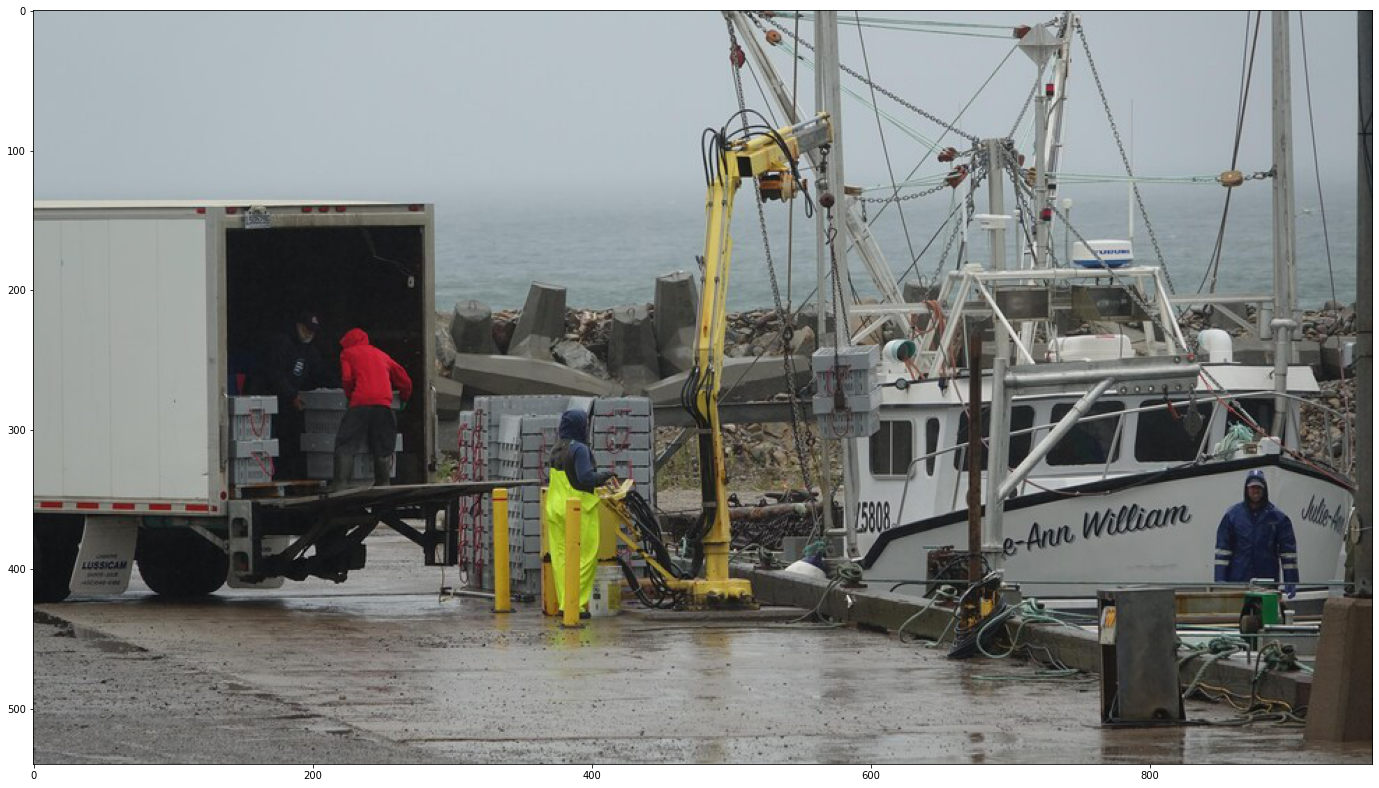

In [14]:
# ['Plage', 'Chiens', 'Taverne à Naxos', 'Bibittes', 'Téléphones', 'Oiseaux', 'Bateaux', 'Pêcheurs']
choix_image = 'Pêcheurs'
retourner_image_horizontalement = False 
convertir_image_gris = False

chemin_vers_images = IMAGES_TEST[choix_image]
image_numpy = lecture_image(chemin_vers_images)

# Retourner l'image horizontalement 
if(retourner_image_horizontalement):
  image_numpy[0] = np.fliplr(image_numpy[0]).copy()

# Convertir l'image en niveaux de gris
if(convertir_image_gris):
  image_numpy[0] = np.tile(
    np.mean(image_numpy[0], 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

plt.figure(figsize=(24,32))
plt.imshow(image_numpy[0])
plt.show()

## Inférence - détection des objets

Pour faire l'inférence (i.e. la détection d'objets), nous avons juste besoin d'appeler notre modèle chargé par TF Hub.

Choses que vous pouvez essayer :

* Imprimez `result['detection_boxes']` et essayez de faire correspondre les emplacements des boîtes aux boîtes de l'image. Notez que les coordonnées sont sous forme normalisée (c'est-à-dire dans l'intervalle [0, 1]).

* Inspectez les autres clés du dictionnaire `resultats` (<i>dictionary keys</i>) de sortie des résultats. Une documentation complète peut être consultée sur la page de documentation des modèles (en consultant l'hyperlien associé au modèle affiché précédemment).

In [15]:
# Procéder à l'inférence (i.e. la détection des objets)
resultats = modele(image_numpy)

# dépendant du modèle de détection d'objets utilisé, le dictionnaire
# contenant les résultats peut comporter des clés supplémentaires
# cela est expliqué dans la documentation
resultats = {key:value.numpy() for key,value in resultats.items()}
print(resultats.keys())

dict_keys(['detection_classes', 'num_detections', 'detection_keypoint_scores', 'detection_keypoints', 'detection_boxes', 'detection_scores'])


## Visualisation des résultats

Ici nous utilisons la bibliothèque de détection d'objets TensorFlow pour afficher les rectangles de l'étape d'inférence (et les points d'ancrage lorsqu'ils sont disponibles).

La documentation complète de cette méthode peut être consultée [ici](https://github.com/tensorflow/models/blob/master/research/object_detection/utils/visualization_utils.py)

Ici, vous pouvez définir `min_score_thresh` entre 0 et 1 pour autoriser plus de détections ou pour filtrer plus de détections.

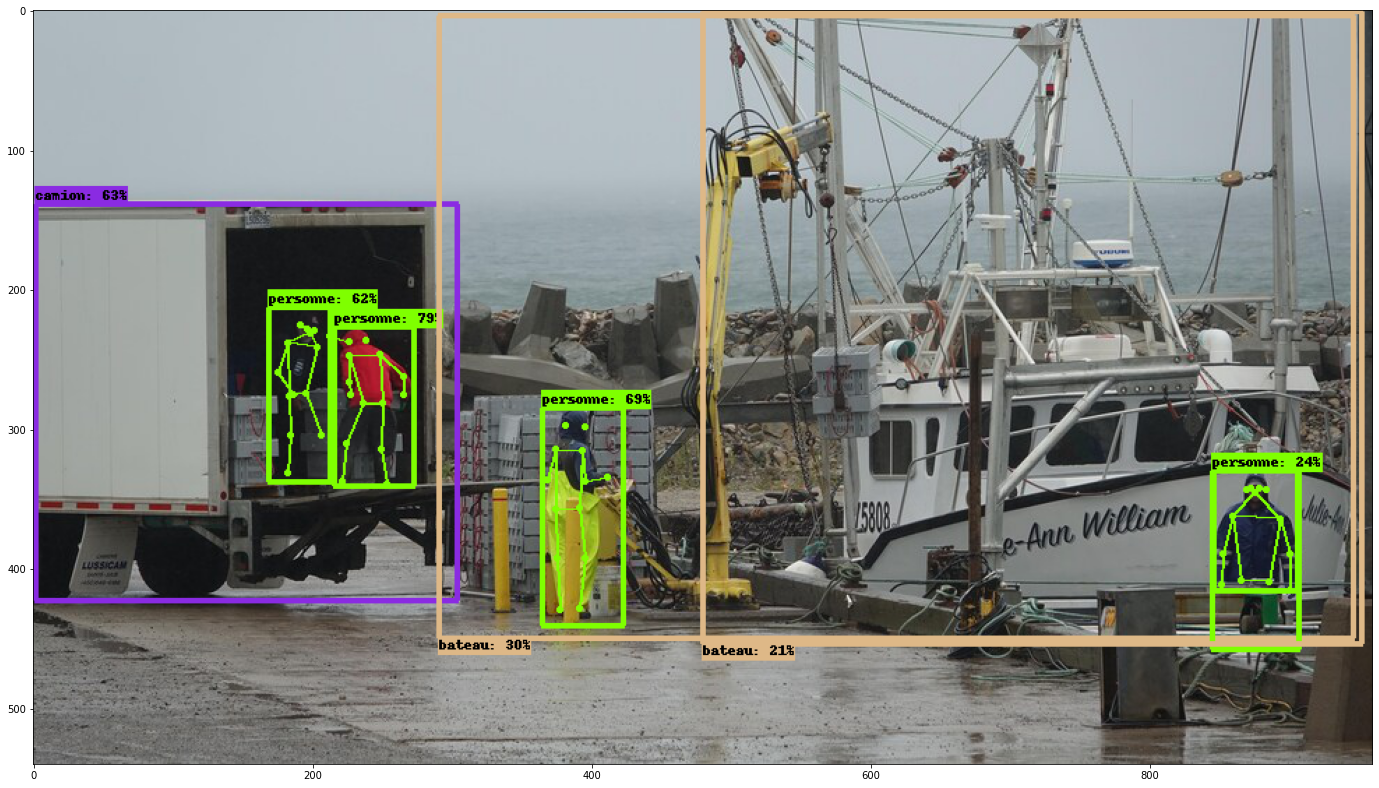

In [16]:
index_etiquette = 0
image_numpy_avec_detections = image_numpy.copy()

# Utilisez les points d'ancrage si disponible
points_ancrage, point_ancrage_scores = None, None
if 'detection_keypoints' in resultats:
  points_ancrage = resultats['detection_keypoints'][0]
  points_ancrage_scores = resultats['detection_keypoint_scores'][0]

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_numpy_avec_detections[0],
      resultats['detection_boxes'][0],
      (resultats['detection_classes'][0] + index_etiquette).astype(int),
      resultats['detection_scores'][0],
      index_etiquettes_classes,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      #pré-réglage original 0.30
      min_score_thresh=.20, 
      agnostic_mode=False,
      keypoints=points_ancrage,
      keypoint_scores=points_ancrage_scores,
      keypoint_edges=COCO17_POINTS_ANCRAGE_POSE_HUMAINE)

plt.figure(figsize=(24,32))
plt.imshow(image_numpy_avec_detections[0])
plt.show()

In [ ]:
print("Fin de l'exécution du carnet IPython")